# **Ransomware Analysis using DEL with jet-like architecture**

> ***Ahsen Nazir***

    Environment: Colab Notebook
    Language: Python 3.7.12
    Framework: PyTorch
    RAM: 32 GB
    GPU: Tesla K80 4992 cores

**CNN1 architecture**

    conv layers = 3
    fc layers = 1
    filter size = (1,4)
    input channels = 1
    output channels = 3
    stride = 1
    padding = none
    output features = 15

**CNN2 architecture**

    conv layers = 4
    fc layers = 1
    filter size = (1,3)
    input channels = 1
    output channels = 3
    stride = 1
    padding = none
    output features = 15

**Sparse encoder**

    linear layers = 8
    dropout = 0.1
    sparsity = 0.00005
    output features = 15

**NLPCA**

    input features = 108
    linear layers = 3
    output features = 15

**MLP**

    linear layers = 3


### Download relevant files

In [ ]:
!mkdir dataset
!mkdir models
!wget -nv -O models/cnn1_4.pt https://github.com/acen20/deep-ensemble-jet/raw/master/models/cnn1_4.pt
!wget -nv -O models/cnn2_5.pt https://github.com/acen20/deep-ensemble-jet/raw/master/models/cnn2_5.pt
!wget -nv -O models/sparse_encoder.pt https://github.com/acen20/deep-ensemble-jet/raw/master/models/sparse_encoder.pt
!wget -nv -O models/undercomplete_encoder.pt https://github.com/acen20/deep-ensemble-jet/raw/master/models/undercomplete_encoder.pt
!wget -nv -O dataset/data.csv https://github.com/acen20/deep-ensemble-jet/raw/master/dataset/data.csv

mkdir: cannot create directory ‘dataset’: File exists
mkdir: cannot create directory ‘models’: File exists
2022-01-20 08:55:29 URL:https://raw.githubusercontent.com/acen20/deep-ensemble-jet/master/models/cnn1_4.pt [17306/17306] -> "models/cnn1_4.pt" [1]
2022-01-20 08:55:30 URL:https://raw.githubusercontent.com/acen20/deep-ensemble-jet/master/models/cnn2_5.pt [19525/19525] -> "models/cnn2_5.pt" [1]
2022-01-20 08:55:31 URL:https://raw.githubusercontent.com/acen20/deep-ensemble-jet/master/models/sparse_encoder.pt [181393/181393] -> "models/sparse_encoder.pt" [1]
2022-01-20 08:55:32 URL:https://raw.githubusercontent.com/acen20/deep-ensemble-jet/master/models/undercomplete_encoder.pt [204021/204021] -> "models/undercomplete_encoder.pt" [1]
2022-01-20 08:55:33 URL:https://raw.githubusercontent.com/acen20/deep-ensemble-jet/master/dataset/data.csv [1283431/1283431] -> "dataset/data.csv" [1]


### Libraries

In [ ]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold as KFold
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [ ]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Loading Dataset
# Dataset link: https://data.mendeley.com/datasets/xvyv59vwvz/1
# Dataset is present in the current directory containing the code file.
df=pd.read_csv('dataset/data.csv')

## Preprocessing

In [ ]:
df.head()

,e_cblp,e_cp,e_cparhdr,e_maxalloc,e_sp,e_lfanew,NumberOfSections,CreationYear,FH_char0,FH_char1,FH_char2,FH_char3,FH_char4,FH_char5,FH_char6,FH_char7,FH_char8,FH_char9,FH_char10,FH_char11,FH_char12,FH_char13,FH_char14,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,OH_DLLchar0,OH_DLLchar1,OH_DLLchar2,OH_DLLchar3,OH_DLLchar4,OH_DLLchar5,OH_DLLchar6,OH_DLLchar7,OH_DLLchar8,OH_DLLchar9,OH_DLLchar10,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,sus_sections,non_sus_sections,packer,packer_type,E_text,E_data,filesize,E_file,fileinfo,class
0,144,3,4,65535,184,256,4,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,8,0,1100288,225792,0,1069880,4096,1110016,0,1,1,4,0,0,0,5,1,1,1,1194954,3,1,0,0,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,3,0,NoPacker,6.603616,5.443362,1181520,6.627552,1,0
1,144,3,4,65535,184,184,4,1,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,5,10,4096,2560,0,7680,4096,8192,1,1,1,4,0,0,0,4,0,1,1,0,2,0,0,0,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,3,0,NoPacker,5.205926,2.123522,7680,5.318221,0,0
2,144,3,4,65535,184,272,5,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,9,0,27648,20480,0,28859,4096,32768,1,1,1,5,0,0,0,5,0,1,1,67688,2,1,0,1,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,4,0,NoPacker,6.238000,3.380859,57872,6.507758,1,0
3,144,3,4,65535,184,184,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,9,0,0,87552,0,0,4096,4096,1,1,1,6,1,6,1,5,0,1,1,113668,2,1,0,1,0,1,0,0,0,0,0,0,1048576,4096,1048576,4096,1,0,1,0,NoPacker,0.000000,0.000000,95616,4.575092,1,0
4,144,3,4,65535,184,224,5,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,10,10,11776,36352,0,13379,4096,16384,1,1,1,6,2,6,2,6,2,1,1,69089,2,1,0,1,0,0,0,0,1,0,0,0,262144,8192,1048576,4096,1,1,4,0,NoPacker,6.355626,0.702621,48128,5.545531,1,0


In [ ]:
# Replacing Null values with 0. ML classifer cannot learn on Null values
df.fillna(0, inplace=True)

In [ ]:
# Peak on dataset
df.head()

,e_cblp,e_cp,e_cparhdr,e_maxalloc,e_sp,e_lfanew,NumberOfSections,CreationYear,FH_char0,FH_char1,FH_char2,FH_char3,FH_char4,FH_char5,FH_char6,FH_char7,FH_char8,FH_char9,FH_char10,FH_char11,FH_char12,FH_char13,FH_char14,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,OH_DLLchar0,OH_DLLchar1,OH_DLLchar2,OH_DLLchar3,OH_DLLchar4,OH_DLLchar5,OH_DLLchar6,OH_DLLchar7,OH_DLLchar8,OH_DLLchar9,OH_DLLchar10,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,sus_sections,non_sus_sections,packer,packer_type,E_text,E_data,filesize,E_file,fileinfo,class
0,144,3,4,65535,184,256,4,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,8,0,1100288,225792,0,1069880,4096,1110016,0,1,1,4,0,0,0,5,1,1,1,1194954,3,1,0,0,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,3,0,NoPacker,6.603616,5.443362,1181520,6.627552,1,0
1,144,3,4,65535,184,184,4,1,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,5,10,4096,2560,0,7680,4096,8192,1,1,1,4,0,0,0,4,0,1,1,0,2,0,0,0,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,3,0,NoPacker,5.205926,2.123522,7680,5.318221,0,0
2,144,3,4,65535,184,272,5,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,9,0,27648,20480,0,28859,4096,32768,1,1,1,5,0,0,0,5,0,1,1,67688,2,1,0,1,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,4,0,NoPacker,6.238000,3.380859,57872,6.507758,1,0
3,144,3,4,65535,184,184,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,9,0,0,87552,0,0,4096,4096,1,1,1,6,1,6,1,5,0,1,1,113668,2,1,0,1,0,1,0,0,0,0,0,0,1048576,4096,1048576,4096,1,0,1,0,NoPacker,0.000000,0.000000,95616,4.575092,1,0
4,144,3,4,65535,184,224,5,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,10,10,11776,36352,0,13379,4096,16384,1,1,1,6,2,6,2,6,2,1,1,69089,2,1,0,1,0,0,0,0,1,0,0,0,262144,8192,1048576,4096,1,1,4,0,NoPacker,6.355626,0.702621,48128,5.545531,1,0


In [ ]:
# Droping these columns due to their insignificance
df=df.drop(['NumberOfSections','CreationYear','e_cblp','e_cp','e_cparhdr','e_maxalloc'], axis=1)

In [ ]:
df.shape

(5210, 64)

In [ ]:
# Peak on the dataset
df.head()

,e_sp,e_lfanew,FH_char0,FH_char1,FH_char2,FH_char3,FH_char4,FH_char5,FH_char6,FH_char7,FH_char8,FH_char9,FH_char10,FH_char11,FH_char12,FH_char13,FH_char14,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,OH_DLLchar0,OH_DLLchar1,OH_DLLchar2,OH_DLLchar3,OH_DLLchar4,OH_DLLchar5,OH_DLLchar6,OH_DLLchar7,OH_DLLchar8,OH_DLLchar9,OH_DLLchar10,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,sus_sections,non_sus_sections,packer,packer_type,E_text,E_data,filesize,E_file,fileinfo,class
0,184,256,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,8,0,1100288,225792,0,1069880,4096,1110016,0,1,1,4,0,0,0,5,1,1,1,1194954,3,1,0,0,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,3,0,NoPacker,6.603616,5.443362,1181520,6.627552,1,0
1,184,184,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,5,10,4096,2560,0,7680,4096,8192,1,1,1,4,0,0,0,4,0,1,1,0,2,0,0,0,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,3,0,NoPacker,5.205926,2.123522,7680,5.318221,0,0
2,184,272,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,9,0,27648,20480,0,28859,4096,32768,1,1,1,5,0,0,0,5,0,1,1,67688,2,1,0,1,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,4,0,NoPacker,6.238000,3.380859,57872,6.507758,1,0
3,184,184,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,9,0,0,87552,0,0,4096,4096,1,1,1,6,1,6,1,5,0,1,1,113668,2,1,0,1,0,1,0,0,0,0,0,0,1048576,4096,1048576,4096,1,0,1,0,NoPacker,0.000000,0.000000,95616,4.575092,1,0
4,184,224,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,10,10,11776,36352,0,13379,4096,16384,1,1,1,6,2,6,2,6,2,1,1,69089,2,1,0,1,0,0,0,0,1,0,0,0,262144,8192,1048576,4096,1,1,4,0,NoPacker,6.355626,0.702621,48128,5.545531,1,0


In [ ]:
ransomware,goodware = df['class'].value_counts()

**Ransomware vs Goodware**

In [ ]:
print(f'Ransomware: {ransomware}')
print(f'Goodware: {goodware}')

Ransomware: 2722
Goodware: 2488


In [ ]:
# Encodings Labels so that they are compatible with machine leanring classifiers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in df:
    if df[i].dtype=='object':
        df[i] = le.fit_transform(df[i])
    else:
        continue
X = df.drop(['class'],axis=1)
y = df['class']

In [ ]:
# Now check the features for the feature column "Packer_type". They are converted fr
df.head()

,e_sp,e_lfanew,FH_char0,FH_char1,FH_char2,FH_char3,FH_char4,FH_char5,FH_char6,FH_char7,FH_char8,FH_char9,FH_char10,FH_char11,FH_char12,FH_char13,FH_char14,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,OH_DLLchar0,OH_DLLchar1,OH_DLLchar2,OH_DLLchar3,OH_DLLchar4,OH_DLLchar5,OH_DLLchar6,OH_DLLchar7,OH_DLLchar8,OH_DLLchar9,OH_DLLchar10,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,sus_sections,non_sus_sections,packer,packer_type,E_text,E_data,filesize,E_file,fileinfo,class
0,184,256,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,8,0,1100288,225792,0,1069880,4096,1110016,0,1,1,4,0,0,0,5,1,1,1,1194954,3,1,0,0,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,3,0,18,6.603616,5.443362,1181520,6.627552,1,0
1,184,184,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,5,10,4096,2560,0,7680,4096,8192,1,1,1,4,0,0,0,4,0,1,1,0,2,0,0,0,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,3,0,18,5.205926,2.123522,7680,5.318221,0,0
2,184,272,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,9,0,27648,20480,0,28859,4096,32768,1,1,1,5,0,0,0,5,0,1,1,67688,2,1,0,1,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,4,0,18,6.238000,3.380859,57872,6.507758,1,0
3,184,184,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,9,0,0,87552,0,0,4096,4096,1,1,1,6,1,6,1,5,0,1,1,113668,2,1,0,1,0,1,0,0,0,0,0,0,1048576,4096,1048576,4096,1,0,1,0,18,0.000000,0.000000,95616,4.575092,1,0
4,184,224,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,10,10,11776,36352,0,13379,4096,16384,1,1,1,6,2,6,2,6,2,1,1,69089,2,1,0,1,0,0,0,0,1,0,0,0,262144,8192,1048576,4096,1,1,4,0,18,6.355626,0.702621,48128,5.545531,1,0


In [ ]:
# Scaling data. Default scaling is to scale the data to unit variance (or equivalent
mms = MinMaxScaler()
X = mms.fit_transform(X)
X = torch.tensor(X, dtype=torch.float)

## CNN Wing 1

In [ ]:
class CNN1(nn.Module):
  def __init__(self):
    super(CNN1, self).__init__()
    self.cnn = nn.Sequential(
        nn.Conv1d(1,3,kernel_size = (1,4), stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(3),
        nn.Conv1d(3,3,kernel_size = (1,4), stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(3),
        nn.Conv1d(3,3,kernel_size = (1,4), stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(3),
        nn.Flatten(),
        nn.Linear(162, 15),
        nn.ReLU()
    )

    self.clf = nn.Sequential(
        nn.Linear(15,1),
        nn.Sigmoid()
    )

  def forward(self, x):
    features = self.cnn(x)
    return self.clf(features)

  def transform(self, x):
    return self.cnn(x)

In [ ]:
cnn1 = CNN1()
cnn1.load_state_dict(torch.load('models/cnn1_4.pt'))
cnn1.eval()
with torch.no_grad():
  f1 = cnn1.transform(X.view(-1,1,1,63))

## CNN Wing 2

In [ ]:
class CNN2(nn.Module):
  final_dims = 15
  def __init__(self):
    super(CNN2, self).__init__()
    self.cnn = nn.Sequential(
        nn.Conv1d(1,3,kernel_size = (1,3), stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(3),
        nn.Conv1d(3,3,kernel_size = (1,3), stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(3),
        nn.Conv1d(3,3,kernel_size = (1,3), stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(3),
        nn.Conv1d(3,3,kernel_size = (1,3), stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(3),
        nn.Flatten(),
        nn.Linear(165, self.final_dims),
        nn.ReLU()
    )

    self.clf = nn.Sequential(
        nn.Linear(15,1),
        nn.Sigmoid()
    )

  def forward(self, x):
    features = self.cnn(x)
    return self.clf(features)

  def transform(self, x):
    return self.cnn(x)

In [ ]:
cnn2 = CNN2()
cnn2.load_state_dict(torch.load('models/cnn2_5.pt'))
cnn2.eval()
with torch.no_grad():
  f2 = cnn2.transform(X.view(-1,1,1,63))

## Sparse AE Tail

In [ ]:
features = 15
current_dims = len(df.columns)-1

In [ ]:
class SparseEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(current_dims, current_dims*2),
        nn.BatchNorm1d(current_dims*2),
        nn.LeakyReLU(),
        nn.Dropout(0.1),
        nn.Linear(current_dims*2, current_dims*2),
        nn.BatchNorm1d(current_dims*2),
        nn.LeakyReLU(),
        nn.Dropout(0.1),
        nn.Linear(current_dims*2, current_dims*2),
        nn.BatchNorm1d(current_dims*2),
        nn.LeakyReLU(),
        nn.Dropout(0.1),
        nn.Linear(current_dims*2, features),
        nn.BatchNorm1d(features),
        nn.LeakyReLU(),
    )

  def forward(self, x):
    encoded = self.encoder(x)
    return encoded

In [ ]:
sparse_ae = SparseEncoder()
sparse_ae.load_state_dict(torch.load('models/sparse_encoder.pt'))
sparse_ae.eval()
with torch.no_grad():
  f3 = sparse_ae(X)

In [ ]:
f1.shape,f2.shape,f3.shape, X.shape

(torch.Size([5210, 15]),
 torch.Size([5210, 15]),
 torch.Size([5210, 15]),
 torch.Size([5210, 63]))

New dimensions after concatenating **F1, F2, F3 and Input**

In [ ]:
new_features = torch.cat((f1,f2,f3,X),dim = 1)
print(new_features.shape)

torch.Size([5210, 108])


## NLPCA Body

In [ ]:
encoded_dims = 15
current_dims = new_features.shape[1]

In [ ]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(current_dims, current_dims*2),
        nn.BatchNorm1d(current_dims*2),
        nn.LeakyReLU(),
        nn.Linear(current_dims*2, current_dims),
        nn.BatchNorm1d(current_dims),
        nn.LeakyReLU(),
        nn.Linear(current_dims,encoded_dims),
    )

  def forward(self, x):
    encoded = self.encoder(x)
    return encoded

In [ ]:
nlpca = Encoder()
nlpca.load_state_dict(torch.load('models/undercomplete_encoder.pt'))
nlpca.eval()
with torch.no_grad():
  f4 = nlpca(new_features)
X = torch.cat((f4,X), dim = 1)

In [ ]:
y = torch.tensor(y, dtype=torch.float)

In [ ]:
X.shape

torch.Size([5210, 78])

In [ ]:
# Dividing data into training, testing and validation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
X_train.shape, y_train.shape

(torch.Size([4168, 78]), torch.Size([4168]))

In [ ]:
pt_train = TensorDataset(X_train, y_train)
pt_train = DataLoader(pt_train, batch_size=32)

## MLP Classifier on new feature space

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(78, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Linear(64, 20),
        nn.BatchNorm1d(20),
        nn.ReLU()
    )
    self.clf = nn.Sequential(
        nn.Linear(20, 1),
        nn.Sigmoid()
    )
  def forward(self, x):
      output = self.model(x)
      return self.clf(output)

In [ ]:
mlp = MLP()
epochs = 50
lr = 1e-2
optimizer = torch.optim.SGD(mlp.parameters(), lr = lr)
criterion = nn.BCELoss()

In [ ]:
losses = []
for epoch in range(epochs):
  for batch_idx, (x, target) in enumerate(pt_train):
    output = mlp(x)
    loss = criterion(output, target.view(-1,1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch_idx == 0:
      print(
          f"Epoch [{epoch+1}/{epochs}] \ "
          f"Loss: {loss.item():.4f}"
      ) 
  losses.append(loss.item())

Epoch [1/50] \ Loss: 0.7002
Epoch [2/50] \ Loss: 0.2365
Epoch [3/50] \ Loss: 0.1636
Epoch [4/50] \ Loss: 0.1271
Epoch [5/50] \ Loss: 0.1030
Epoch [6/50] \ Loss: 0.0849
Epoch [7/50] \ Loss: 0.0737
Epoch [8/50] \ Loss: 0.0667
Epoch [9/50] \ Loss: 0.0614
Epoch [10/50] \ Loss: 0.0568
Epoch [11/50] \ Loss: 0.0520
Epoch [12/50] \ Loss: 0.0482
Epoch [13/50] \ Loss: 0.0458
Epoch [14/50] \ Loss: 0.0400
Epoch [15/50] \ Loss: 0.0395
Epoch [16/50] \ Loss: 0.0354
Epoch [17/50] \ Loss: 0.0315
Epoch [18/50] \ Loss: 0.0273
Epoch [19/50] \ Loss: 0.0254
Epoch [20/50] \ Loss: 0.0235
Epoch [21/50] \ Loss: 0.0209
Epoch [22/50] \ Loss: 0.0188
Epoch [23/50] \ Loss: 0.0166
Epoch [24/50] \ Loss: 0.0157
Epoch [25/50] \ Loss: 0.0149
Epoch [26/50] \ Loss: 0.0135
Epoch [27/50] \ Loss: 0.0119
Epoch [28/50] \ Loss: 0.0124
Epoch [29/50] \ Loss: 0.0118
Epoch [30/50] \ Loss: 0.0116
Epoch [31/50] \ Loss: 0.0094
Epoch [32/50] \ Loss: 0.0103
Epoch [33/50] \ Loss: 0.0089
Epoch [34/50] \ Loss: 0.0087
Epoch [35/50] \ Loss: 0

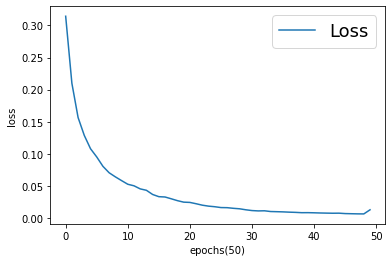

In [ ]:
plt.plot(losses)
plt.xlabel(f"epochs({epochs})")
plt.ylabel(f"loss")
_ = plt.legend(['Loss'])

In [ ]:
_ = mlp.eval()

In [ ]:
with torch.no_grad():
  lr_probs_1 = mlp(X_test).squeeze()
  ml_pred = lr_probs_1.round()

In [ ]:
cm = confusion_matrix(y_test, ml_pred)
tn=cm[0][0] #tn
fn=cm[0][1] #fn
fp=cm[1][0] #fp
tp=cm[1][1] #tp
acc= (tp+tn)/(tp+tn+fn+fp)
epsilon = 1e-7 # is used so that to avoid divide by zero error
precision = tp / (tp + fp + epsilon)
recall = tp / (tp + fn + epsilon)
sensitivity,specificity = tp/(tp+fn),tn/(tn+fp)
print("Test accuracy is:"+str(format(acc,'.4f')))
print("Precision: "+str(format(precision,'.4f'))+" Recall: "+str(format(recall,'.4f')))

Test accuracy is:0.9616
Precision: 0.9658 Recall: 0.9585


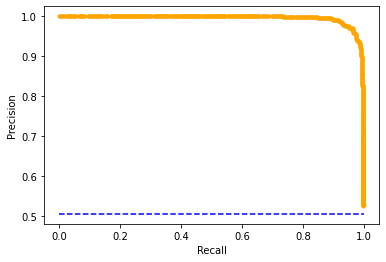

F1:	 96.212%
AUC:	 99.494%
Accuracy:96.161%


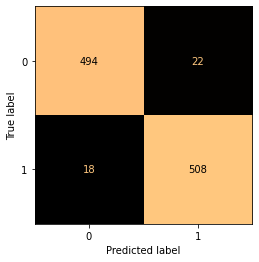

In [ ]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs_1)
lr_f1, lr_auc = f1_score(y_test, ml_pred), auc(lr_recall, lr_precision)
no_skill = len(y_test[y_test==1]) / len(y_test)
acc = accuracy_score(y_test, ml_pred)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', c = "blue")
plt.plot(lr_recall, lr_precision, marker='.', c = "orange")
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')

# show the plot
plt.show()
_ = plt.rc('legend', fontsize=18)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(cmap="copper", colorbar = False)
print(f"F1:\t {lr_f1*100:.3f}%")
print(f"AUC:\t {lr_auc*100:.3f}%")
print(f"Accuracy:{acc*100:.3f}%")

In [ ]:
torch.save(mlp.state_dict(), 'models/mlp.pt')